In [30]:
%matplotlib notebook
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop, ToTensor, Compose, Resize
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
from tqdm import trange

torch.manual_seed(69)

In [31]:
trans = {
    'test': Compose([Resize((256, 256)), ToTensor()]),
    'train': Compose([
        Resize((256, 256)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        ToTensor()
    ])
}

train_imgs = ImageFolder(
    root='./dataset/training/training',
    transform=trans['train']
)
test_imgs = ImageFolder(
    root='./dataset/validation/validation',
    transform=trans['test']
)
BS = 64
train_dtld = DataLoader(train_imgs,
                       shuffle=True,
                       batch_size=BS)
test_dtld = DataLoader(test_imgs,
                      shuffle=True,
                      batch_size=BS)

In [32]:
len(train_dtld)

18

<IPython.core.display.Javascript object>


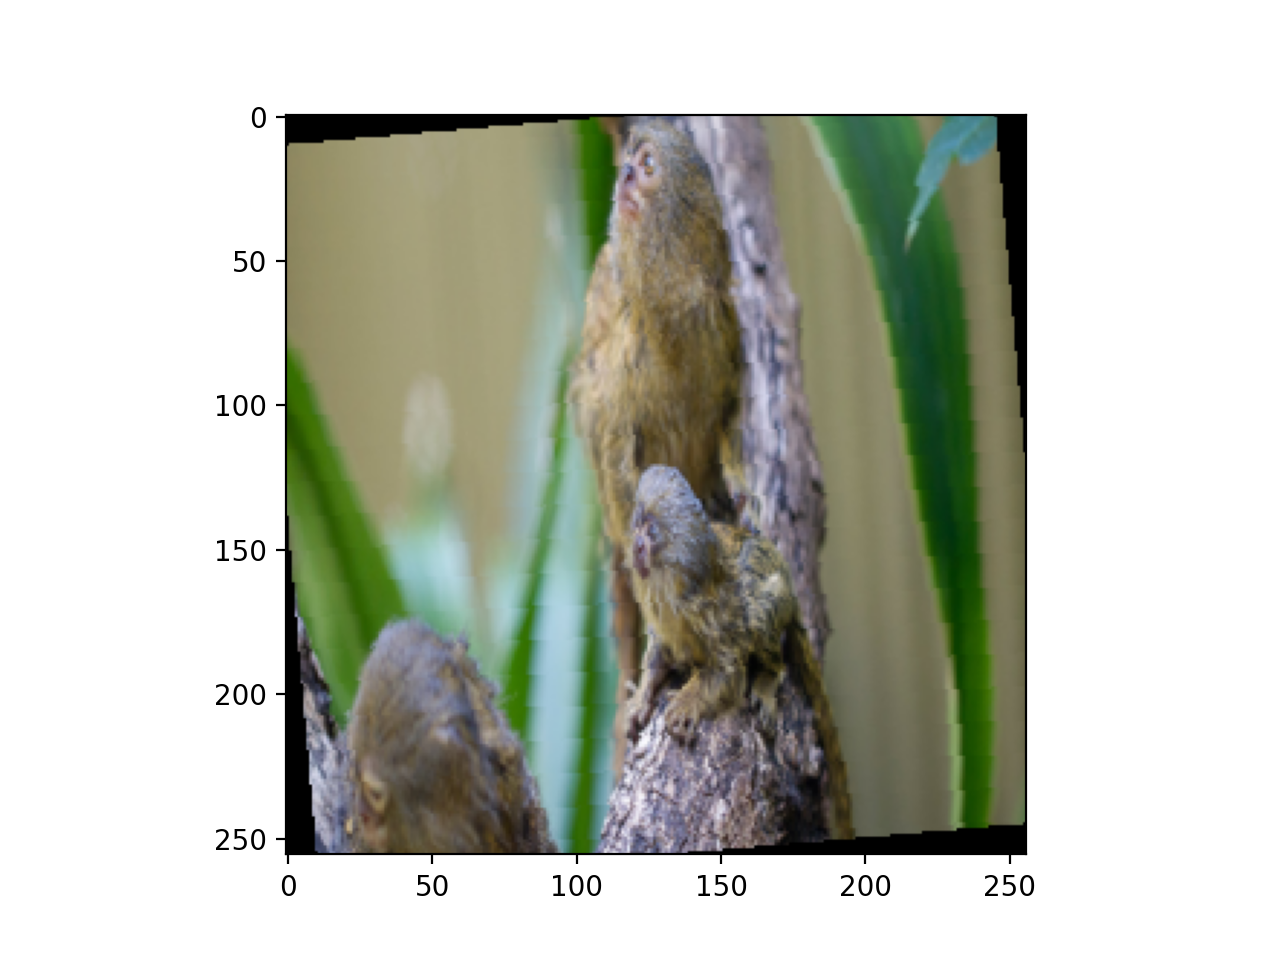

In [33]:
for x, y in train_dtld:
    plt.imshow(torch.movedim(x[0], 0, 2))
    break

In [54]:
def plot(figs, axs, test_axs, train_losses, test_losses, train_accs, test_accs):
    axs[0].clear()
    test_axs[0].clear()
    axs[0].plot(train_losses['iteration'], label='Train')
    test_axs[0].plot(test_losses['iteration'], 'y', label='Test')
    axs[0].set_title('Iteration Losses')
    axs[0].legend()
    test_axs[0].legend()

    axs[1].clear()
    test_axs[1].clear()
    axs[1].plot(train_accs['iteration'], label='Train')
    test_axs[1].plot(test_accs['iteration'], 'y', label='Test')
    axs[1].set_ylim(-.1, 1.1)
    axs[1].set_title('Itetarion Accs')
    axs[1].legend()
    test_axs[1].legend()
    
    axs[2].clear()
    axs[2].plot(train_losses['epoch'], label='Train')
    axs[2].plot(test_losses['epoch'], 'y', label='Test')
    axs[2].set_title('Epoch Losses')
    axs[2].legend()

    axs[3].clear()
    axs[3].plot(train_accs['epoch'], label='Train')
    axs[3].plot(test_accs['epoch'], 'y', label='Test')
    axs[3].set_ylim(-.1, 1.1)
    axs[3].set_title('Epoch Accs')
    axs[3].legend()
    [fig.canvas.draw() for fig in figs]

In [55]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.Conv2d(64, 96, kernel_size=3),
            nn.Conv2d(96, 128, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 128, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )
        self.flat = nn.Flatten()
        self.l = nn.Sequential(
            nn.Linear(18432, 8018),
            nn.ReLU(),
            nn.Linear(8018, 4012),
            nn.ReLU(),
            nn.Linear(4012, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        return self.l(x)
model = BobNet()
test_losses, test_accs = {'epoch': [], 'iteration': []}, {'epoch': [], 'iteration': []}
train_losses, train_accs = {'epoch': [], 'iteration': []}, {'epoch': [], 'iteration': []}

<IPython.core.display.Javascript object>


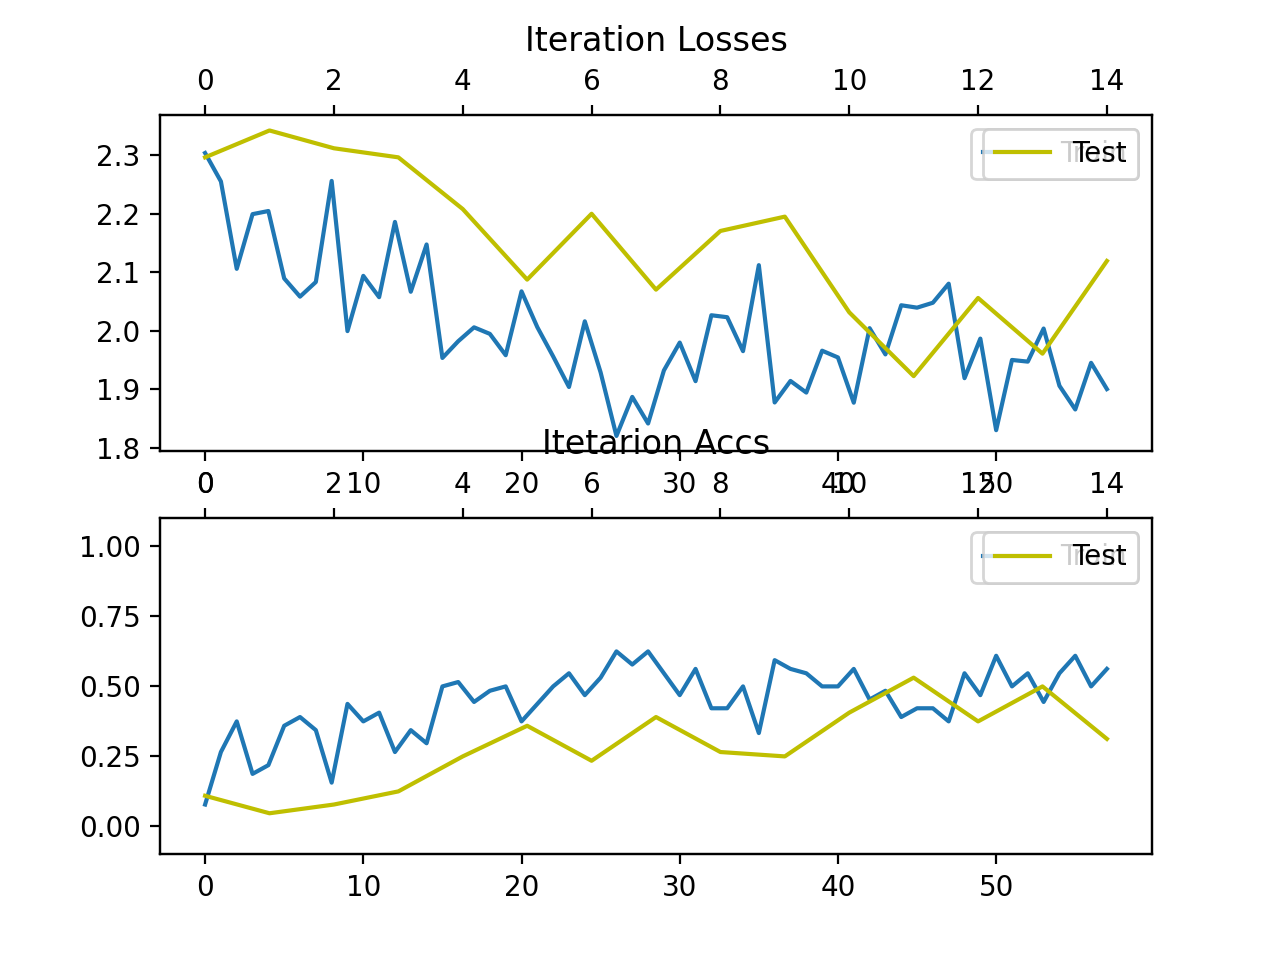

In [56]:
fig, axs = plt.subplots(2,1)
test_axs = (axs[0].twiny(), axs[1].twiny())

<IPython.core.display.Javascript object>


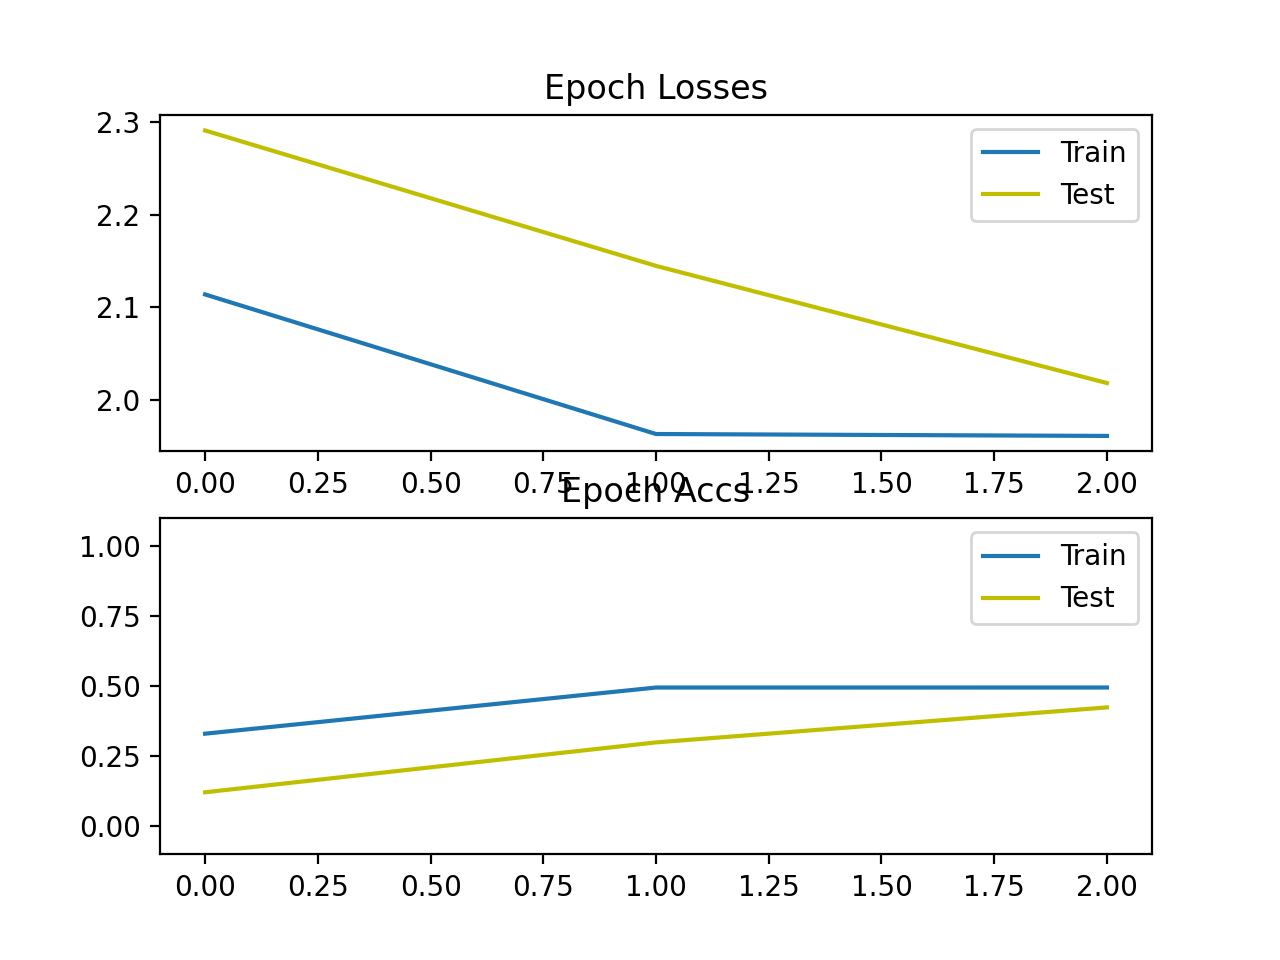

In [57]:
fig2, axs2 = plt.subplots(2, 1)
axs = [ax for ax in axs] + [ax for ax in axs2]
figs = [fig, fig2]

In [58]:
epochs = 10
optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
loss_fn  = nn.CrossEntropyLoss()

def do_epoch(dtld, train=True):
    model.train(mode=train)
    losses, accs = [], []
    for X, Y in dtld:
        for p in model.parameters():
            p.grad = None
        #Fordward
        pred = model(X)
        Y_hat = torch.argmax(pred, dim=1)
        acc = (Y_hat == Y).float().mean()
        loss = loss_fn(pred, Y)
        # Backward
        if train:
            loss.backward()
            optim.step()
        # Save data
        loss = loss.item(); acc = acc.item()
        if train:
            train_losses['iteration'].append(loss), train_accs['iteration'].append(acc)
        else:
            test_losses['iteration'].append(loss), test_accs['iteration'].append(acc)
        losses.append(loss), accs.append(acc)
        plot(figs, axs, test_axs, train_losses, test_losses, train_accs, test_accs)
    if train:
        train_losses['epoch'].append(torch.tensor(losses).mean())
        train_accs['epoch'].append(torch.tensor(accs).mean())
    else:
        test_losses['epoch'].append(torch.tensor(losses).mean())
        test_accs['epoch'].append(torch.tensor(accs).mean())
    
for _ in (t:=trange(epochs)):
    do_epoch(train_dtld)
    do_epoch(test_dtld, train=False)
    t.set_description(f"TRAIN Loss={train_losses['epoch'][-1]:.2f} Acc={train_accs['epoch'][-1]:.2f}\
 // TEST Loss={test_losses['epoch'][-1]:.2f} Acc={test_accs['epoch'][-1]:.2f}")

TRAIN Loss=1.96 Acc=0.50 // TEST Loss=2.02 Acc=0.43:  30%|███       | 3/10 [19:10<44:44, 383.48s/it]


KeyboardInterrupt: 

In [50]:
acc = []
for X_test, Y_test in test_dtld:
    pred = model(X_test)
    Y_hat = torch.argmax(pred, dim=1)
    acc.append((Y_hat == Y_test).float().mean())
    X_test[Y_hat != Y_test]
torch.tensor(acc).mean()

tensor(0.3656)